In [1]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import sklearn 
import sklearn.preprocessing

In [2]:
# params
seed = 42

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data',
                 header = None, sep = ' ')

# based on the .doc data description
df.columns = ['cheq_acc', 'dur_t', 'cred_hist', 'purp', 'cred_amt', 'save_acc', 
              'empl_t', 'inst_to_income', 'pers_status', 'guarant_flg',
              'residence_t', 'prop', 'age', 'inst_plan', 'house', 'n_loans',
              'job', 'n_depend', 'tel_flg', 'foreign_flg', 'target']

df.head()

,cheq_acc,dur_t,cred_hist,purp,cred_amt,save_acc,empl_t,inst_to_income,pers_status,guarant_flg,...,prop,age,inst_plan,house,n_loans,job,n_depend,tel_flg,foreign_flg,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
X = df.loc[:, df.columns != 'target']
y = df.target - 1

In [5]:
df = pd.read_csv("credit_train.csv", sep = ',')
df = df[:-514]
del df["Loan ID"]
del df["Customer ID"]
df = df.rename(columns={'Loan Status': 'target'}) 
df['Purpose'] = df['Purpose'].replace('other', 'Other')
df['target'] = df['target'].replace('Fully Paid', 0)
df['target'] = df['target'].replace('Charged Off', 1)
df['Years in current job'] = df['Years in current job'].fillna('Unknown')

In [6]:
X = df.loc[:, df.columns != 'target']
y = df.target

In [5]:
#Подготовка
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


def Gini(y, y_pred):
    res = roc_auc_score(y, y_pred) * 2 - 1
    return(res)

In [6]:
from modules.encoders import WoEEncoder_adj
from feature_engine.encoding import OneHotEncoder
OneHot_module = OneHotEncoder()
WoE_module = WoEEncoder_adj()

In [7]:
StScal_mdl = sklearn.preprocessing.StandardScaler()
MMScal_mdl = sklearn.preprocessing.MinMaxScaler(feature_range=(1, 2))
RobScal_mdl = sklearn.preprocessing.RobustScaler()

In [8]:
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer
from feature_engine.transformation import PowerTransformer
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import YeoJohnsonTransformer

WinsTrans_module = Winsorizer()
LogTrans_module  = LogTransformer(base = '10')
PwrTrans_module  = PowerTransformer(exp = 0.5)
BxCxTrans_module = BoxCoxTransformer()
YeoJTrans_module = YeoJohnsonTransformer()


In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

RUS_module    = RandomUnderSampler(random_state = seed)
ROS_module    = RandomOverSampler(random_state = seed)
SMOTE_module  = SMOTE(random_state = seed)
ADASYN_module = ADASYN(random_state = seed)

In [10]:
from feature_engine.selection  import SmartCorrelatedSelection
SmartSel_module = SmartCorrelatedSelection(
    # variables=X.columns.to_list(),
    method="pearson",                # можно взять свою функцию
    threshold=0.3,                   # порог корреляции
    selection_method="variance",     # из коррелирующих групп выбираем признак с наиб дисперсией
    estimator=None,                  # понадобится для selection_method="model_performance"        
    cv=5
)
from feature_engine.selection  import RecursiveFeatureAddition
RecFeatAdd_module = RecursiveFeatureAddition( # rather slow
    lgbm_mdl,
    threshold = 0.005
)

NameError: name 'lgbm_mdl' is not defined

In [13]:
# import umap
import umap.umap_ as umap

class DimensionReducer():
    """
    Ugly wrapper fir various dimension reduction classes. Needed for 2 reasons:
    1. Features are not replaced, new ones are just added to df
    2. PCA output: np.array, should be replaced with pd.DataFrame 
    
    Comment AM: 
    1. Could be united with TransformerAdj class below, 
    2. .super() could be used
    """
    def __init__(self, gen_class, affx='feat', **kwargs):
        self.reducer = gen_class(**kwargs)
        self.affx = affx
        # self.reducer.set_params()
        
    def fit(self, X, y):
        self.reducer.fit(X, y)
        return self
    
    def transform(self, X):
        # potentially 
        Z = self.reducer.transform(X)
        return Z
    
    def set_params(self, **kwargs):
        self.reducer.set_params(**kwargs)
        return self  


Isomap_module = DimensionReducer(
    gen_class = sklearn.manifold.Isomap,
    n_neighbors = 5, #количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 15,  #сколько оставить компонент; по дефолту - 2
    path_method = "auto", #алгоритм, который вычисляет кратчайший путь. Варианты см. на странице функции. Этот подбирает сам.
    neighbors_algorithm = "auto", #алгоритм, который ищет соседей. Инстанс класса NearestNeighbours
    n_jobs = -1 #объект умеет быть многопоточным! -1 займет все ядра
)

PCA_module = DimensionReducer(
    gen_class = sklearn.decomposition.PCA,
    n_components = 2,    # сколько оставить компонентов; по дефолту - все
    whiten = False,      # отключаем whitening - декорреляцию фичей
    svd_solver = "full", # детали SVD преобразования, за подробностями см. доки
)

UMAP_module = DimensionReducer(
    gen_class = umap.UMAP,
    n_neighbors = 5,  # количество соседей при вычислении KNN. Основной гиперпараметр, кстати (!!!)
    n_components = 2, # сколько оставить компонентов; по дефолту - 2
    min_dist = 0.1    # минимальная дистанция, которую можно сохранять между точками в получающемся пространстве. 
    # Гиперпараметр. При увеличении начинает лучше улавливать общую структуру, но хуже - локальную
)

In [14]:
train = pd.concat([y, X], axis=1)
X_train_b = []
y_train_b = []
X_bag = []
y_bag = []
for i in range (100):
    a = (train.sample(n = 800,  replace=True, random_state = i))
    b = pd.concat([train, a, a]).drop_duplicates(keep=False)
    X_train_b.append(a.loc[:, a.columns != 'target'])
    y_train_b.append(a.target)
    X_bag.append(b.loc[:, b.columns != 'target'])
    y_bag.append(b.target)

In [15]:
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import RandomSampleImputer
from modules.missings import teach_to_separate
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from modules.missings import missing_filler_mode

MedImp_module = MeanMedianImputer(imputation_method='median')
MeanImp_module = MeanMedianImputer(imputation_method='mean')
ModeImp_module = missing_filler_mode()
RandomImp_module = RandomSampleImputer()
KNNImp_module = teach_to_separate(KNNImputer)
IterImp_module = teach_to_separate(IterativeImputer)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

knn = KNeighborsClassifier()

mdl_pipe_impute = imbPipeline(
    [('mis', MedImp_module),
        ('encode', OneHot_module),
     ('RobScal', StScal_mdl),
     ('Win', WinsTrans_module),
     ('imb', ADASYN_module),
     #('select', PCA_module),
     ('model', knn)]
)

search_space = {
    'model__n_neighbors':     hp.choice('model__n_neighbors',       np.arange(1, 50, 1, dtype=int)),
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|█████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.50trial/s, best loss: -0.69]


In [17]:
results_lgbm = pd.DataFrame({"full" : gini})
results1_lgbm = pd.DataFrame({"full" : b_acc})
results2_lgbm = pd.DataFrame({"full" : f1})

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

knn = KNeighborsClassifier()

mdl_pipe_impute = imbPipeline(
    [('mis', MedImp_module),
        ('encode', OneHot_module),
     #('RobScal', StScal_mdl),
     ('Win', WinsTrans_module),
     ('imb', ADASYN_module),
     #('select', PCA_module),
     ('model', knn)]
)

search_space = {
    'model__n_neighbors':     hp.choice('model__n_neighbors',       np.arange(1, 50, 1, dtype=int)),
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:13<00:00,  2.89trial/s, best loss: -0.618]


In [19]:
results_lgbm['No Scaling'] = gini
results1_lgbm['No Scaling'] = b_acc
results2_lgbm['No Scaling'] = f1

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

knn = KNeighborsClassifier()

mdl_pipe_impute = imbPipeline(
    [('mis', MedImp_module),
        ('encode', OneHot_module),
     ('RobScal', StScal_mdl),
     #('Win', WinsTrans_module),
     ('imb', ADASYN_module),
     #('select', PCA_module),
     ('model', knn)]
)

search_space = {
    'model__n_neighbors':     hp.choice('model__n_neighbors',       np.arange(1, 50, 1, dtype=int)),
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.51trial/s, best loss: -0.674]


In [21]:
results_lgbm['No transformation'] = gini
results1_lgbm['No transformation'] = b_acc
results2_lgbm['No transformation'] = f1

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

knn = KNeighborsClassifier()

mdl_pipe_impute = imbPipeline(
    [('mis', MedImp_module),
        ('encode', WoE_module),
     ('RobScal', StScal_mdl),
     ('Win', WinsTrans_module),
     ('imb', ADASYN_module),
     #('select', PCA_module),
     ('model', knn)]
)

search_space = {
    'model__n_neighbors':     hp.choice('model__n_neighbors',       np.arange(1, 50, 1, dtype=int)),
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.96trial/s, best loss: -0.678]


In [23]:
results_lgbm['No OneHot encoding'] = gini
results1_lgbm['No OneHot encoding'] = b_acc
results2_lgbm['No OneHot encoding'] = f1

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.model_selection import cross_val_score, StratifiedKFold
seed = 42
lgbm_mdl = LGBMClassifier(
    num_leaves = 12,
    learning_rate = .1,
    reg_alpha = 0,
    reg_lambda = 9,
    n_estimators= 100,
    random_state = seed
)

knn = KNeighborsClassifier()

mdl_pipe_impute = imbPipeline(
    [('mis', MedImp_module),
        ('encode', WoE_module),
     ('RobScal', StScal_mdl),
     ('Win', WinsTrans_module),
     #('imb', ADASYN_module),
     #('select', PCA_module),
     ('model', knn)]
)

search_space = {
    'model__n_neighbors':     hp.choice('model__n_neighbors',       np.arange(1, 50, 1, dtype=int)),
                }




def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}


trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=mdl_pipe_impute, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=40,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )
from hyperopt import space_eval
best_params = space_eval(search_space, best)
mdl_pipe_impute.set_params(**best_params)

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
mdl_pipe_impute.fit(X, y)
c = Gini(y, mdl_pipe_impute.predict_proba(X)[:, 1])
c1 = balanced_accuracy_score(y, mdl_pipe_impute.predict(X))
c2 = f1_score(y, mdl_pipe_impute.predict(X))
gini = []
b_acc = []
f1 = []
for i in range(100):

    mdl_pipe_impute.fit(X_train_b[i], y_train_b[i])

    gini.append(0.632*Gini(y_bag[i], mdl_pipe_impute.predict_proba(X_bag[i])[:, 1]) + c*0.368)
    b_acc.append(0.632*balanced_accuracy_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c1*0.368)
    f1.append(0.632*f1_score(y_bag[i], mdl_pipe_impute.predict(X_bag[i])) + c2*0.368)

100%|████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.60trial/s, best loss: -0.752]


In [25]:
results_lgbm['No Imbalanced data module'] = gini
results1_lgbm['No Imbalanced data module'] = b_acc
results2_lgbm['No Imbalanced data module'] = f1

In [26]:
results_lgbm.mean()

full                         0.561745
No Scaling                   0.388037
No transformation            0.547679
No OneHot encoding           0.530958
No Imbalanced data module    0.547889
dtype: float64

In [27]:
results1_lgbm.mean()

full                         0.755948
No Scaling                   0.664147
No transformation            0.750591
No OneHot encoding           0.705537
No Imbalanced data module    0.631903
dtype: float64

In [28]:
results2_lgbm.mean()

full                         0.661373
No Scaling                   0.537507
No transformation            0.654807
No OneHot encoding           0.590327
No Imbalanced data module    0.446521
dtype: float64

In [29]:
results_lgbm.std()

full                         0.029864
No Scaling                   0.032366
No transformation            0.027415
No OneHot encoding           0.025223
No Imbalanced data module    0.025406
dtype: float64

In [30]:
results1_lgbm.std()

full                         0.014011
No Scaling                   0.014450
No transformation            0.013799
No OneHot encoding           0.014292
No Imbalanced data module    0.013844
dtype: float64

In [31]:
results2_lgbm.std()

full                         0.020373
No Scaling                   0.022434
No transformation            0.019379
No OneHot encoding           0.018336
No Imbalanced data module    0.029923
dtype: float64

In [32]:
from scipy import stats
stats.ttest_ind(results_lgbm['full'], results_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=3.469621974198986, pvalue=0.000640471767892328)

In [33]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=2.7240480291120046, pvalue=0.00702557818542576)

In [34]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No transformation'], equal_var = False)

Ttest_indResult(statistic=2.335073369249982, pvalue=0.02054370352133747)

In [35]:
stats.ttest_ind(results_lgbm['full'], results_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=39.44441361856564, pvalue=2.2448586034957182e-95)

In [36]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=45.61010775720375, pvalue=6.338375309802873e-107)

In [37]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No Scaling'], equal_var = False)

Ttest_indResult(statistic=40.8742770841115, pvalue=6.285845950503135e-98)

In [38]:
stats.ttest_ind(results_lgbm['full'], results_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=7.875860721502322, pvalue=2.412175203796525e-13)

In [39]:
stats.ttest_ind(results1_lgbm['full'], results1_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=25.187268826232145, pvalue=1.2020354474681439e-63)

In [40]:
stats.ttest_ind(results2_lgbm['full'], results2_lgbm['No OneHot encoding'], equal_var = False)

Ttest_indResult(statistic=25.91976352674763, pvalue=3.228264705959291e-65)

[Text(0.5, 1.0, 'KNN and preprocessing')]

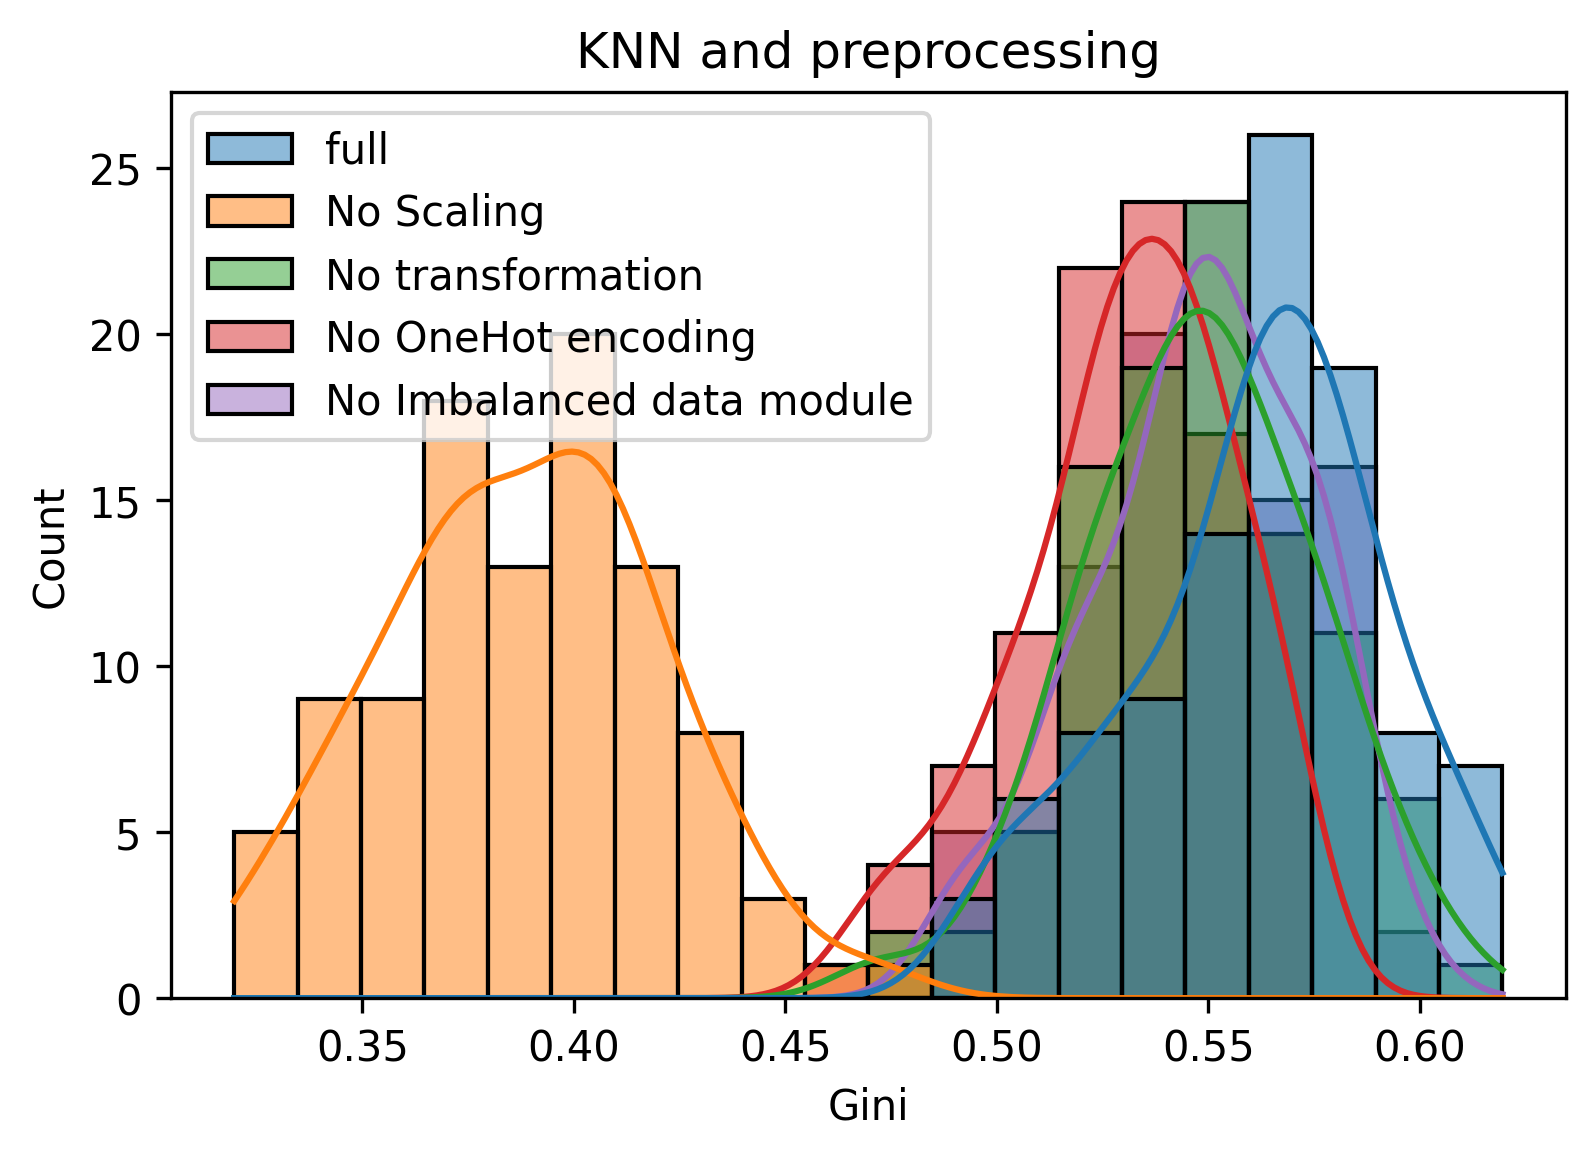

In [41]:
plt.rcParams['figure.dpi'] = 300
ax = sns.histplot(results_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Gini", fontsize = 10)
ax.set(title='KNN and preprocessing')

[Text(0.5, 1.0, 'KNN and preprocessing')]

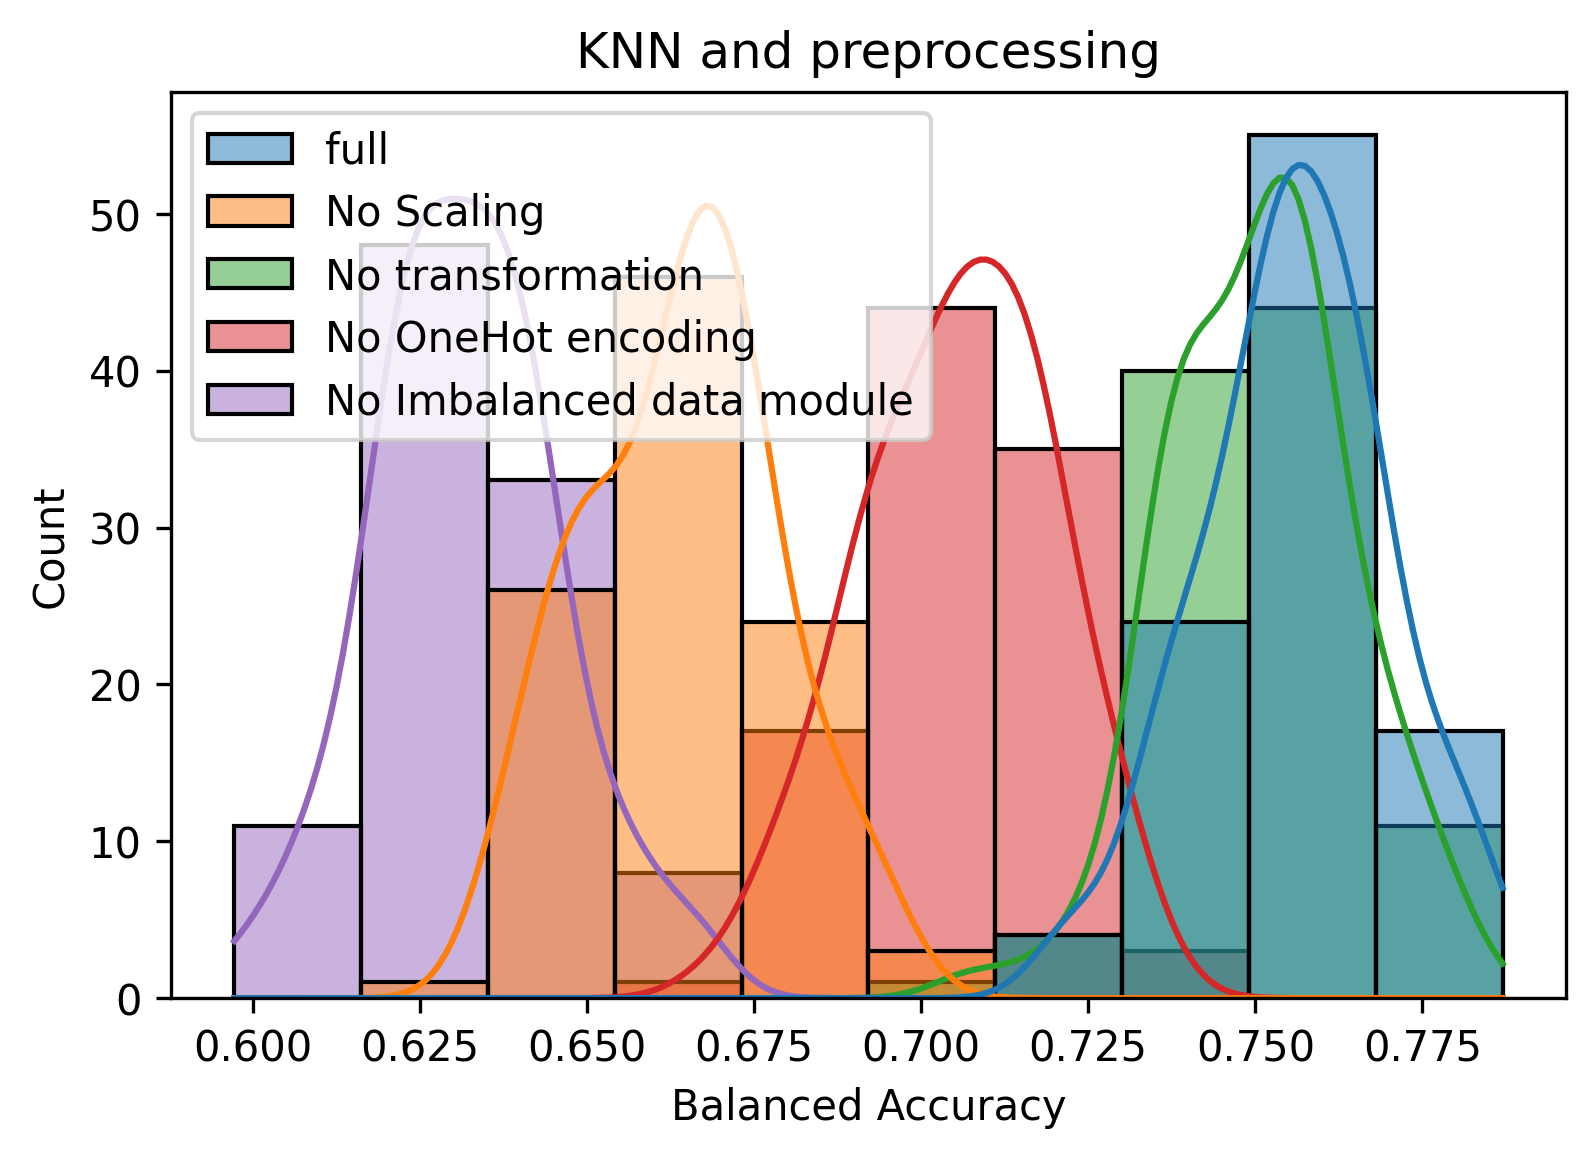

In [44]:
ax = sns.histplot(results1_lgbm, kde=True, element = 'bars')
ax.set_xlabel("Balanced Accuracy", fontsize = 10)
ax.set(title='KNN and preprocessing')


[Text(0.5, 1.0, 'KNN and preprocessing')]

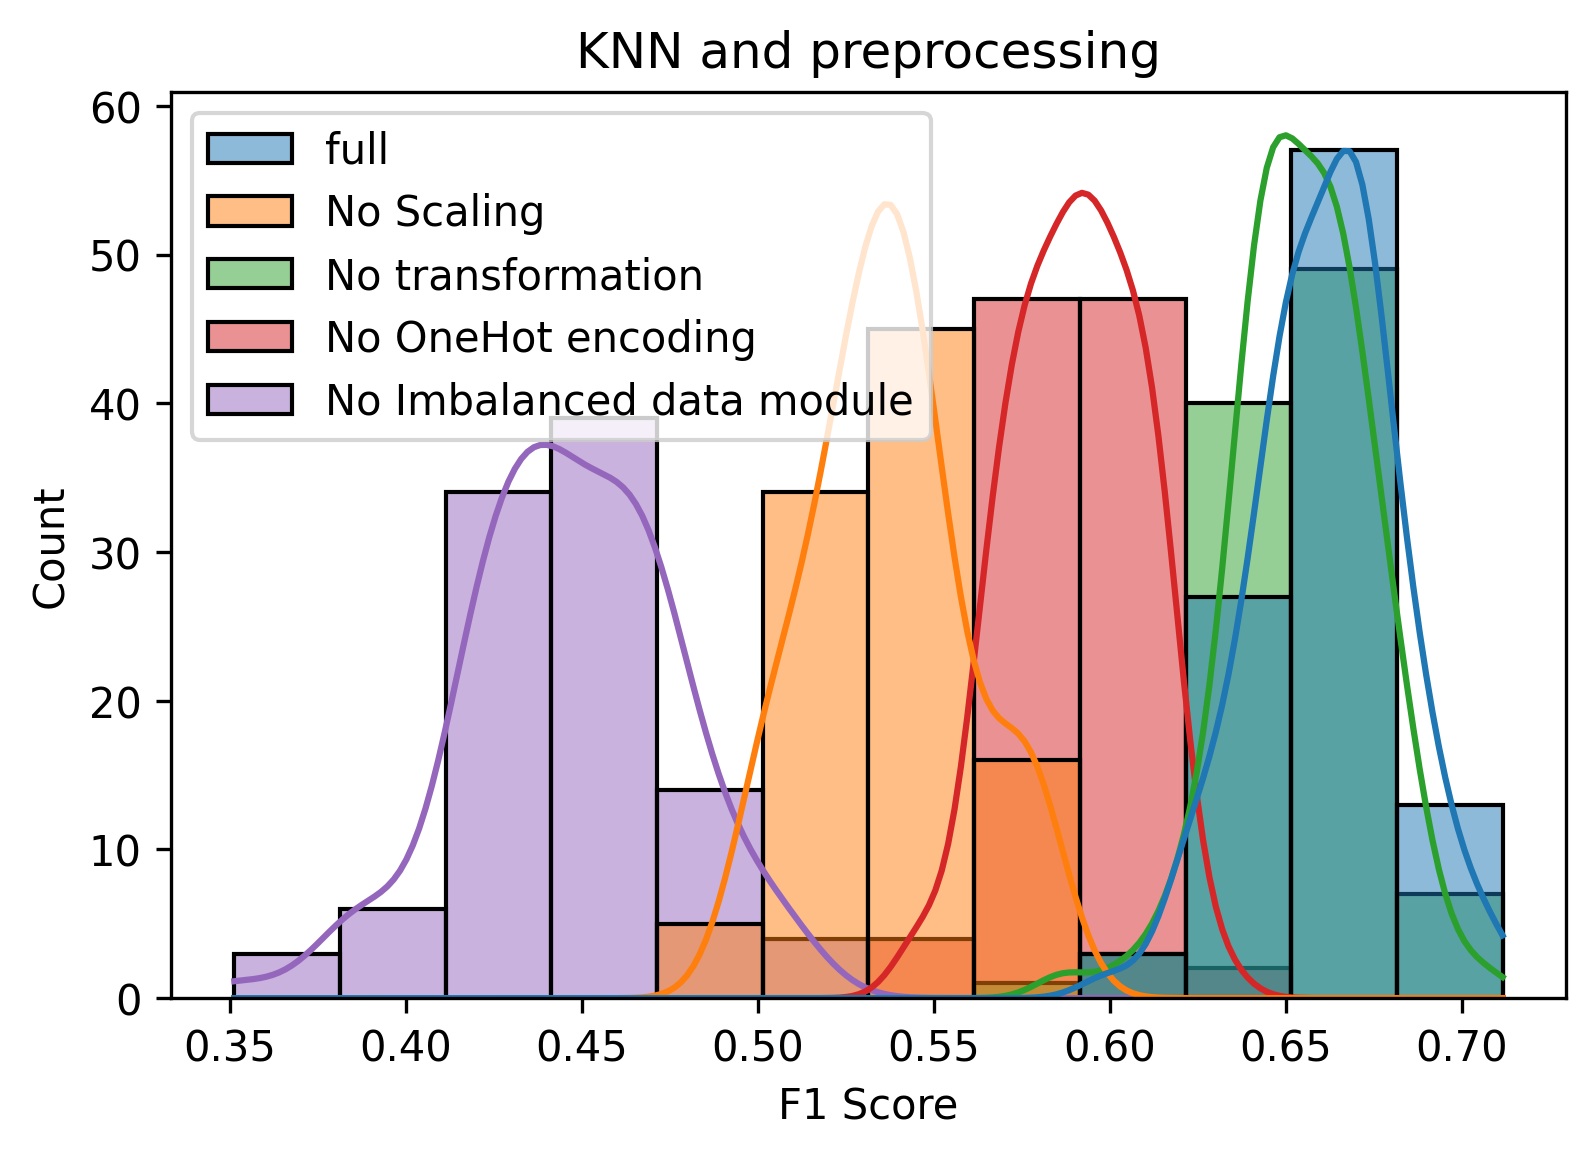

In [43]:
ax = sns.histplot(results2_lgbm, kde=True, element = 'bars')
ax.set_xlabel("F1 Score", fontsize = 10)
ax.set(title='KNN and preprocessing')